# Profiling ray.put()

In [1]:
import ray
import cProfile
import pstats
import StringIO
import time
import sys
import string
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ray.init()

Waiting for redis server at 127.0.0.1:29553 to respond...
Waiting for redis server at 127.0.0.1:58879 to respond...
Starting local scheduler with the following resources: {'GPU': 0, 'CPU': 4}.

View the web UI at http://localhost:8909/notebooks/ray_ui89901.ipynb?token=bedd9fd01ce2db14bbda79f39e78717513c998f5dc22db1c



{'local_scheduler_socket_names': ['/tmp/scheduler87044079'],
 'node_ip_address': '127.0.0.1',
 'object_store_addresses': [ObjectStoreAddress(name='/tmp/plasma_store32559637', manager_name='/tmp/plasma_manager52276148', manager_port=11174)],
 'redis_address': '127.0.0.1:29553',
 'webui_url': 'http://localhost:8909/notebooks/ray_ui89901.ipynb?token=bedd9fd01ce2db14bbda79f39e78717513c998f5dc22db1c'}

## Functions

In [3]:
def get_profile_data(arr):
    pr = cProfile.Profile()
    pr.enable()
    ray.put(arr)
    pr.disable()
    return pr

In [4]:
def stats_printer(profile_object):
    s = StringIO.StringIO()
    sortby = 'module'
    ps = pstats.Stats(profile_object, stream=s).sort_stats(sortby)
    ps.strip_dirs()
    ps.print_stats('put|plasma|store_and_register')
    print s.getvalue()

In [5]:
def print_profile_data_raw(arr):
    pr = get_profile_data(arr)
    stats_printer(pr)

In [6]:
def print_profile_data_clean(arr):
    profile_data = get_profile_data(arr)
    put = 0.0
    
    print 'ncalls' + '\t' + 'inlinetime' + '\t' +'tottime' + '\t' + '\t' + 'filename(function)'
    for line in profile_data.getstats():
        code = line.code
        if type(code) is not str:
            code = code.co_filename.split('/')[-1]+":"+code.co_name

        ncalls = line.callcount
        tottime = "%.6f" % line.totaltime
        inlinetime = "%.6f" % line.inlinetime
        
        if 'put' in code or 'plasma' in code or 'store_and_register' in code:
            print str(ncalls) + '\t' + str(inlinetime) + '\t' + str(tottime) + '\t' + str(code)

In [7]:
def get_plasma_put_time(arr):
    profile_data = get_profile_data(arr)
    put = 0.0
    
    for line in profile_data.getstats():
        code = line.code
        if type(code) is not str:
            code = code.co_filename.split('/')[-1]+":"+code.co_name
            
        if code == "<method 'put' of 'pyarrow.plasma.PlasmaClient' objects>":
            put = line.totaltime

    return put

## Test Inputs

In [22]:
NUM_STRINGS = 2*10**5
STRING_LENGTH = 20
short_numpy_array = np.array([1,2,3,4,5])

In [23]:
large_numpy_array = np.array([i for i in range(NUM_STRINGS)])

In [24]:
very_large_numpy_array = np.array([i for i in range(NUM_STRINGS * 10)])

In [25]:
large_string_array = [''.join(random.choice(string.ascii_letters) for _ in range(STRING_LENGTH)) for _ in range(NUM_STRINGS)]

In [26]:
array_of_large_integers = [np.random.randint(0, sys.maxsize) for _ in range(NUM_STRINGS * 10)]

In [27]:
large_string_array_asints = np.array([[ord(c) for c in s] for s in large_string_array], dtype=np.uint8)

In [29]:
print("Size of short numpy array: " + str(sys.getsizeof(short_numpy_array)/1024/1024) + " MB")
print("Size of large numpy array: " + str(sys.getsizeof(large_numpy_array)/1024/1024) + " MB")
print("Size of very large numpy array: " + str(sys.getsizeof(very_large_numpy_array)/1024/1024) + " MB")
print("Size of large string array: " + str(sys.getsizeof(large_string_array)/1024/1024) + " MB")
print("Size of large integer array: " + str(sys.getsizeof(array_of_large_integers)/1024/1024) + " MB")
print("Size of string array as ints: " + str(sys.getsizeof(large_string_array_asints)/1024/1024) + " MB")

Size of short numpy array: 0 MB
Size of large numpy array: 1 MB
Size of very large numpy array: 15 MB
Size of large string array: 1 MB
Size of large integer array: 16 MB
Size of string array as ints: 3 MB


## Profiling Results

In [30]:
print_profile_data_clean(short_numpy_array)

ncalls	inlinetime	tottime		filename(function)
1	0.000028	0.000028	<method 'compute_put_id' of 'local_scheduler.LocalSchedulerClient' objects>
1	0.000023	0.002444	worker.py:store_and_register
1	0.000012	0.002458	worker.py:put_object
1	0.000031	0.002561	worker.py:put
1	0.002421	0.002421	<method 'put' of 'pyarrow.plasma.PlasmaClient' objects>


In [31]:
print_profile_data_clean(large_numpy_array)

ncalls	inlinetime	tottime		filename(function)
1	0.000028	0.000028	<method 'compute_put_id' of 'local_scheduler.LocalSchedulerClient' objects>
1	0.000018	0.004975	worker.py:store_and_register
1	0.000009	0.004986	worker.py:put_object
1	0.000028	0.005087	worker.py:put
1	0.004957	0.004957	<method 'put' of 'pyarrow.plasma.PlasmaClient' objects>


In [32]:
print_profile_data_clean(very_large_numpy_array)

ncalls	inlinetime	tottime		filename(function)
1	0.000028	0.000028	<method 'compute_put_id' of 'local_scheduler.LocalSchedulerClient' objects>
1	0.000017	0.016693	worker.py:store_and_register
1	0.000007	0.016703	worker.py:put_object
1	0.000025	0.016807	worker.py:put
1	0.016675	0.016675	<method 'put' of 'pyarrow.plasma.PlasmaClient' objects>


In [33]:
print_profile_data_clean(large_string_array)

ncalls	inlinetime	tottime		filename(function)
1	0.000028	0.000028	<method 'compute_put_id' of 'local_scheduler.LocalSchedulerClient' objects>
1	0.000018	0.061744	worker.py:store_and_register
1	0.000006	0.061752	worker.py:put_object
1	0.000021	0.061845	worker.py:put
1	0.061725	0.061725	<method 'put' of 'pyarrow.plasma.PlasmaClient' objects>


In [34]:
print_profile_data_clean(array_of_large_integers)

ncalls	inlinetime	tottime		filename(function)
1	0.000025	0.000025	<method 'compute_put_id' of 'local_scheduler.LocalSchedulerClient' objects>
1	0.000020	0.270654	worker.py:store_and_register
1	0.000005	0.270661	worker.py:put_object
1	0.000018	0.270740	worker.py:put
1	0.270633	0.270633	<method 'put' of 'pyarrow.plasma.PlasmaClient' objects>


In [35]:
print_profile_data_clean(large_string_array_asints)

ncalls	inlinetime	tottime		filename(function)
1	0.000023	0.000023	<method 'compute_put_id' of 'local_scheduler.LocalSchedulerClient' objects>
1	0.000014	0.006213	worker.py:store_and_register
1	0.000007	0.006222	worker.py:put_object
1	0.000026	0.006309	worker.py:put
1	0.006199	0.006199	<method 'put' of 'pyarrow.plasma.PlasmaClient' objects>


## Plots

[1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]
[0.00039579999999999997, 0.00033150000000000003, 0.0002761, 0.0012675, 0.0005989999999999999, 0.0017467, 0.0075423, 0.08639559999999999]


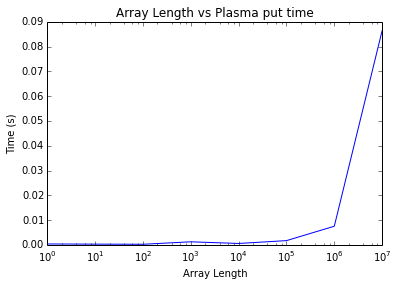

In [21]:
xs = [10**i for i in range(8)]
ys = []
for x in xs:
    samples = []
    for j in range(10):
        samples.append(get_plasma_put_time(np.array([np.random.randint(0, sys.maxsize) for _ in range(x)])))
    ys.append(np.average(samples))
    
print(xs)
print(ys)

plt.title('Array Length vs Plasma put time')
plt.xlabel('Array Length')
plt.xscale('log')
plt.ylabel('Time (s)')
plt.plot(xs, ys)